# Naive Bayes Classification with TREC Dataset
<hr>

We will build a text classification model using Naive Bayes on the TREC question Dataset. We will use the default size of train/test split from the original source. 
## Load the library

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import random
from nltk.corpus import stopwords, twitter_samples
# from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import KFold
from nltk.stem import PorterStemmer
from string import punctuation
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
import time

%config IPCompleter.greedy=True
%config IPCompleter.use_jedi=False
# nltk.download('twitter_samples')

## Load the Dataset

In [3]:
corpus = pd.read_pickle('../0_data/TREC/TREC.pkl')
corpus.label = corpus.label.astype(int)
print(corpus.shape)
corpus

(5952, 3)


sentence  label  split
0     how did serfdom develop in and then leave russ...      0  train
1      what films featured the character popeye doyle ?      1  train
2     how can i find a list of celebrities ' real na...      0  train
3     what fowl grabs the spotlight after the chines...      1  train
4                       what is the full form of .com ?      2  train
...                                                 ...    ...    ...
5947             who was the 22nd president of the us ?      3   test
5948             what is the money they use in zambia ?      1   test
5949                          how many feet in a mile ?      5   test
5950                what is the birthstone of october ?      1   test
5951                                   what is e coli ?      0   test

[5952 rows x 3 columns]

In [4]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5952 entries, 0 to 5951
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  5952 non-null   object
 1   label     5952 non-null   int32 
 2   split     5952 non-null   object
dtypes: int32(1), object(2)
memory usage: 116.4+ KB


In [12]:
corpus.groupby( by=['split','label']).count()

sentence
split label          
test  0           138
      1            94
      2             9
      3            65
      4            81
      5           113
train 0          1162
      1          1250
      2            86
      3          1223
      4           835
      5           896

In [24]:
np.array(corpus[corpus.split=='train'].label)

array([5, 4, 3, 0, 5, 5, 3, 1, 0, 0, 4, 3, 5, 3, 5, 5, 1, 3, 0, 5, 3, 0,
       4, 0, 0, 3, 0, 4, 4, 4, 5, 4, 0, 5, 5, 5, 4, 5, 5, 5, 1, 0, 0, 0,
       1, 1, 5, 0, 5, 3, 0, 3, 3, 0, 0, 0, 5, 4, 4, 5, 4, 3, 4, 1, 4, 3,
       1, 0, 5, 4, 5, 5, 4, 3, 4, 0, 1, 5, 5, 3, 0, 5, 3, 5, 5, 0, 0, 3,
       0, 4, 1, 0, 5, 5, 3, 4, 5, 0, 0, 1, 0, 3, 0, 3, 4, 0, 5, 1, 5, 4,
       1, 0, 5, 3, 1, 3, 5, 1, 5, 4, 5, 5, 0, 3, 5, 3, 5, 5, 0, 5, 5, 3,
       0, 1, 0, 1, 4, 3, 3, 0, 0, 1, 4, 1, 0, 1, 3, 1, 0, 0, 1, 3, 0, 5,
       3, 4, 4, 0, 4, 4, 0, 0, 5, 4, 1, 4, 5, 0, 4, 3, 5, 5, 5, 0, 4, 4,
       4, 5, 1, 5, 4, 0, 4, 0, 1, 3, 3, 0, 4, 1, 1, 5, 5, 5, 0, 4, 1, 3,
       1, 1, 1, 4, 3, 1, 5, 4, 3, 5, 0, 0, 5, 5, 4, 4, 0, 1, 0, 1, 5, 0,
       0, 5, 0, 1, 4, 1, 5, 0, 4, 3, 5, 3, 0, 5, 1, 0, 4, 0, 4, 5, 4, 0,
       0, 0, 0, 4, 0, 0, 0, 1, 3, 4, 1, 1, 0, 4, 5, 1, 0, 5, 3, 3, 5, 1,
       5, 0, 0, 4, 5, 0, 1, 0, 0, 3, 0, 0, 0, 5, 2, 1, 4, 3, 2, 0, 4, 0,
       0, 0, 0, 0, 4, 1, 5, 1, 0, 0, 1, 5, 1, 1, 2,

In [25]:
# Separate the sentences and the labels for training and testing
train_x = list(corpus[corpus.split=='train'].sentence)
train_y = np.array(corpus[corpus.split=='train'].label)
print(len(train_x))
print(len(train_y))

test_x = list(corpus[corpus.split=='test'].sentence)
test_y = np.array(corpus[corpus.split=='test'].label)
print(len(test_x))
print(len(test_y))


5452
5452
500
500


## Raw Number of Vocabulary

In [16]:
# Build the raw vocobulary for first inspection
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus.sentence)
vocab_raw = tokenizer.word_index
print('\nThe vocabulary size: {}\n'.format(len(vocab_raw)))
print(vocab_raw)


The vocabulary size: 8759

{'the': 1, 'what': 2, 'is': 3, 'of': 4, 'in': 5, 'a': 6, 'how': 7, "'s": 8, 'was': 9, 'who': 10, 'to': 11, 'are': 12, 'for': 13, 'and': 14, 'did': 15, 'does': 16, "''": 17, 'do': 18, 'name': 19, 'on': 20, 'many': 21, 'where': 22, 'first': 23, 'when': 24, 'i': 25, 'you': 26, 'can': 27, 'from': 28, 'world': 29, 's': 30, 'u': 31, 'which': 32, 'that': 33, 'most': 34, 'by': 35, 'an': 36, 'country': 37, 'as': 38, 'city': 39, 'with': 40, 'have': 41, 'has': 42, 'why': 43, 'it': 44, 'there': 45, 'year': 46, 'state': 47, 'called': 48, 'be': 49, 'president': 50, 'people': 51, 'at': 52, 'get': 53, 'were': 54, 'find': 55, 'his': 56, 'american': 57, 'mean': 58, 'two': 59, 'largest': 60, 'war': 61, 'made': 62, 'new': 63, 'much': 64, 'fear': 65, 'long': 66, 'between': 67, "'": 68, 'its': 69, 'used': 70, 'word': 71, 'known': 72, 'origin': 73, 'day': 74, 'company': 75, 'kind': 76, 'movie': 77, 'about': 78, 'tv': 79, 'one': 80, 'film': 81, 'all': 82, 'famous': 83, 'stand': 84,

<!--## Split Dataset-->

# Data Preprocessing
<hr>

## Define `clean_doc` function

In [26]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stemmer = PorterStemmer()
    
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
#     tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    tokens = [w for w in tokens if not w in stopwords]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) >= 1]
    # Stem the token
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

## Define `count_docs` function

In [27]:
def count_docs(data, docs, ys):
    '''
    Input:
        data: a dictionary that will be used to map each pair to its frequency
        docs: a list of sentences
        ys: a list corresponding to the sentiment of each tweet (either 0 or 1)
    Output:
        result: a dictionary mapping each pair to its frequency
    '''
    onehot = OneHotEncoder( sparse=False)
    y_onehot = onehot.fit_transform(np.reshape(ys, (-1,1)))
    # print(y_onehot)
    count = 0                    
    for doc, y in zip(docs, y_onehot):
        # For each word
        for word in clean_doc(doc):
            # if not in the data yet
            if word not in data:
                # assign it
                data[word] = y
            # if already in the data 
            else:
                # update it
                data[word] = data.get(word) + y

    return data

## Build Frequencies Dictionary

In [29]:
# Build the freqs dictionary for later uses
freqs = count_docs({}, train_x, train_y)
freqs

{'serfdom': array([1., 0., 0., 0., 0., 0.]),
 'develop': array([2., 3., 0., 5., 1., 1.]),
 'leav': array([2., 0., 0., 1., 1., 4.]),
 'russia': array([1., 0., 0., 1., 1., 2.]),
 'film': array([ 3., 38.,  0., 11.,  1.,  4.]),
 'featur': array([ 3., 23.,  0.,  1.,  2.,  0.]),
 'charact': array([ 2.,  8.,  0., 28.,  1.,  3.]),
 'popey': array([0., 2., 0., 2., 0., 0.]),
 'doyl': array([0., 1., 0., 0., 0., 0.]),
 'find': array([28.,  4.,  0.,  0., 52.,  3.]),
 'list': array([3., 1., 0., 0., 8., 0.]),
 'celebr': array([1., 5., 0., 6., 1., 1.]),
 'real': array([3., 2., 0., 7., 1., 2.]),
 'name': array([ 39., 133.,   3., 171.,  42.,   4.]),
 'fowl': array([0., 1., 0., 0., 0., 0.]),
 'grab': array([0., 2., 0., 0., 0., 0.]),
 'spotlight': array([0., 1., 0., 0., 0., 0.]),
 'chines': array([4., 2., 0., 2., 1., 1.]),
 'year': array([ 5.,  7.,  0., 15.,  2., 85.]),
 'monkey': array([0., 2., 0., 0., 0., 1.]),
 'full': array([0., 2., 2., 3., 3., 0.]),
 'form': array([9., 8., 2., 4., 1., 2.]),
 'com': a

In [30]:
# convert the freqs dictionary to nested list
def freqs_to_df(freqs, train_y):
    '''
    input:
        freqs: a frequencies dictionary (ex: {'simplist': array([15.,  4.]), 
                                              'silli': array([64., 20.]), . . })
        train_y: labels for data
    output:
        a frequencies dictionary in the form of dataframe
    '''
    # initialize an empty list to store the rows for dataframe
    freqs_list = []
    
    # Define the names of the dataframe columns
    column_names = ['word']
    column_names = column_names + list(np.unique(train_y))
    
    # convert the keys from the freqs dictionary to a list
    keys = list(freqs.keys())

    # For each row
    for i in range(len(freqs)):
        
        # define the elements for each column
        row = [keys[i]] + list(freqs.get(keys[i]))
        
        # update the frequency list
        freqs_list.append(row)
    
    # Create the dataframe
    df = pd.DataFrame(freqs_list, columns=column_names)
    df.set_index('word', inplace=True)
    return df

In [31]:
freqs_df = freqs_to_df(freqs, train_y)
freqs_df

0     1    2     3    4    5
word                                     
serfdom    1.0   0.0  0.0   0.0  0.0  0.0
develop    2.0   3.0  0.0   5.0  1.0  1.0
leav       2.0   0.0  0.0   1.0  1.0  4.0
russia     1.0   0.0  0.0   1.0  1.0  2.0
film       3.0  38.0  0.0  11.0  1.0  4.0
...        ...   ...  ...   ...  ...  ...
rico       0.0   0.0  0.0   0.0  0.0  1.0
repossess  1.0   0.0  0.0   0.0  0.0  0.0
butcher    0.0   1.0  0.0   0.0  0.0  0.0
spine      0.0   1.0  0.0   0.0  0.0  0.0
currenc    0.0   2.0  0.0   0.0  0.0  0.0

[6840 rows x 6 columns]

In [34]:
freqs_df[5].sum()

4411.0

# Training and Testing the Model

## Build Training Function

In [35]:
def train_naive_bayes(freq_df, train_x, train_y):
    '''
    Input:
        freqs: a pandas dataframe with word indexing
        train_x: a list of tweets
        train_y: a list of labels correponding to the tweets (0,1)
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    
    freqs = freq_df

    # calculate V, the number of unique words in the vocabulary
    vocab = list(freqs.index)
    V = len(vocab)
    
    ########################################################################################
    # Part 1: Calculate the log prior probability for each class
    
    # Calculate D, the number of documents
    D = len(train_y)
    
    labels = list(np.unique(train_y.astype(int)))
    count = np.zeros((len(labels),))

    for train_label in train_y:
        for unique_label in labels:
            if train_label == unique_label:
                count[unique_label]+=1
                
    # -> count = [4000, 4000]; it means perfectly balanced between each classese

    # Calculate prior probability for each class
    prior = count/D # -> prior = array([0.5, 0.5])
    
        
    # Calculate the logprior for each class
    logprior = np.log(prior) # -> prior = array([-0.69314718, -0.69314718])
    
    ########################################################################################
    # Part 2.a. Calculate the total number of word occurrences for each class
    
    columns = list(freqs.columns)
    N_classes = []
    # calculate N frequency for each class
    for column in columns:
        
        freqs[column] = (freqs[column] + 1)/(freqs[column].sum()+V)
        
    # Calculate the log likelihood of the word
    loglikelihood = np.log(freqs)
        
    ########################################################################################
        
    return logprior, loglikelihood

In [36]:
labels = np.array(labels)
logprior, loglikelihood = train_naive_bayes(freqs_df, sentences, labels)
print(logprior)
loglikelihood

[-1.52136303 -1.48807706 -4.13760568 -1.53063667 -1.87146621 -1.77476756]


0         1         2         3         4         5
word                                                                 
serfdom   -8.601718 -9.484557 -8.866582 -9.513994 -9.283777 -9.328212
develop   -8.196253 -8.098263 -8.866582 -7.722235 -8.590630 -8.635065
leav      -8.196253 -9.484557 -8.866582 -8.820847 -8.590630 -7.718774
russia    -8.601718 -9.484557 -8.866582 -8.820847 -8.590630 -8.229600
film      -7.908571 -5.820996 -8.866582 -7.029088 -8.590630 -7.718774
...             ...       ...       ...       ...       ...       ...
rico      -9.294865 -9.484557 -8.866582 -9.513994 -9.283777 -8.635065
repossess -8.601718 -9.484557 -8.866582 -9.513994 -9.283777 -9.328212
butcher   -9.294865 -8.791410 -8.866582 -9.513994 -9.283777 -9.328212
spine     -9.294865 -8.791410 -8.866582 -9.513994 -9.283777 -9.328212
currenc   -9.294865 -8.385945 -8.866582 -9.513994 -9.283777 -9.328212

[6840 rows x 6 columns]

## Build Testing Function

In [37]:
def naive_bayes_predict(tweet, logprior, loglikelihood):
    '''
    input:
        tweet: a string
        logprior: initial probability based on dataset
        loglikelihood: a dictionary of words mapping to numbers
    output:
        p: the sum of all the loglikelihood of each word in the tweet
        (if found in the dictionary) + logprior (a number)
    '''
    
    # process the tweet to get the list of words
    words = clean_doc(tweet)
    
    
    # Initialize probability to zero
    probs = []
    columns = list(loglikelihood.columns)
    for column in columns:
        prob = 0
        # Iterate for each word in word list
        for word in words:

            # check if the word exist in the loglikelihood dictionary
            if word in loglikelihood.index:
                prob += loglikelihood.loc[word, column]
        
        probs.append(prob)
        
    probs = logprior + probs
    y_hat = np.argmax(probs)
    
    return probs, y_hat

In [75]:
def test_naive_bayes(test_x, logprior, loglikelihood):
    """
    input:
        test_x: A list of tweets
        test_y: the corresponding labels for the list of tweets
        logprior: the logprior
        loglikelihood: a dictionary with the loglikelihoods for each word
    output:
        accuracy: (# of tweets classified correctly)/total # of tweets
    """
    # initial accuracy
    acc = 0
    
    # initialize an empty list for storing the predictions
    y_hats = []

    for tweet in test_x:
        
        _ , y = naive_bayes_predict(tweet, logprior, loglikelihood)
        
#         y_hat = np.argmax(probs)
        
        # update the y_hats
        y_hats.append(y)
        
#     Error: the mean absolute values between y_hats and test_y
#     error = np.mean(np.abs(np.array(y_hats)-np.array(test_y)))
        
#     Accuracy is 1 - error
#     acc = 1-error
#     return acc 
    
    y_hats = np.array(y_hats)
    
    return y_hats

## Train and Test!

5452
5452
500
500
           0     1    2     3    4    5
word                                   
serfdom  1.0   0.0  0.0   0.0  0.0  0.0
develop  2.0   3.0  0.0   5.0  1.0  1.0
leav     2.0   0.0  0.0   1.0  1.0  4.0
russia   1.0   0.0  0.0   1.0  1.0  2.0
film     3.0  38.0  0.0  11.0  1.0  4.0

Word sum: 4042.0 | 6315.0 | 251.0 | 6708.0 | 3922.0 | 4411.0 

logprior:  [-1.54583986 -1.47283896 -4.1493905  -1.49467566 -1.87630607 -1.80579738]

loglikelihood:                    0         1         2         3         4         5
word                                                                 
serfdom   -8.601718 -9.484557 -8.866582 -9.513994 -9.283777 -9.328212
develop   -8.196253 -8.098263 -8.866582 -7.722235 -8.590630 -8.635065
leav      -8.196253 -9.484557 -8.866582 -8.820847 -8.590630 -7.718774
russia    -8.601718 -9.484557 -8.866582 -8.820847 -8.590630 -8.229600
film      -7.908571 -5.820996 -8.866582 -7.029088 -8.590630 -7.718774
...             ...       ...       ...       

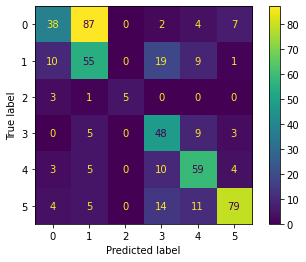

In [76]:
###################################################
# Training and Testing using the Train/Test Split #
###################################################

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Separate the sentences and the labels for training and testing
train_x = list(corpus[corpus.split=='train'].sentence)
train_y = np.array(corpus[corpus.split=='train'].label)
print(len(train_x))
print(len(train_y))

test_x = list(corpus[corpus.split=='test'].sentence)
test_y = np.array(corpus[corpus.split=='test'].label)
print(len(test_x))
print(len(test_y))

# Build the freqs dictionary for later uses
freqs = count_docs({}, train_x, train_y)

# Turn the frequencies dictionary into dataframe
freqs_df = freqs_to_df(freqs, train_y)
print(freqs_df.head())
print('\nWord sum: {} | {} | {} | {} | {} | {} '.format(freqs_df[0].sum(),
                                                      freqs_df[1].sum(),
                                                      freqs_df[2].sum(),
                                                      freqs_df[3].sum(),
                                                      freqs_df[4].sum(),
                                                      freqs_df[5].sum()) )

# Retrieve the logprior and loglikelihood
logprior, loglikelihood = train_naive_bayes(freqs_df, train_x, train_y)
print('\nlogprior: ', logprior)
print('\nloglikelihood: ', loglikelihood)

y_hats = test_naive_bayes(test_x, logprior, loglikelihood)
print('y_test: ', test_y)
print('y_predict: ', y_hats)

CM = confusion_matrix(test_y, y_hats)
print(ConfusionMatrixDisplay(CM).plot())
print('\nNaive Bayes accuracy: ', accuracy_score(test_y, y_hats))